In [1]:
# Database Dependencies
import pymongo
import gridfs
import pandas as pd
import io
import numpy as np
from PIL import Image, ImageOps
import os
import glob
import re
from config import DB_NAME, FEAT_3_COLLECTION_NAME, FEAT_30_COLLECTION_NAME
import json 

# Machine Learning Dependencies
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Plotting Dependencies
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Neural Network Dependencies
import tensorflow as tf
from tensorflow import keras

# Database Connection and Loading Data

In [2]:
# Establish mongo instance and get Music database
client = pymongo.MongoClient('localhost')
db = client[DB_NAME]

In [3]:
# Select 'feat_3' collection, and read in as pandas DataFrame
collection = db[FEAT_3_COLLECTION_NAME].find()
features_3_df = pd.DataFrame(list(collection))

# Drop mongo generated hash-code id column
features_3_df = features_3_df.drop(columns = ["_id"])
features_3_df

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0     blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
1     blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
2     blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3     blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4     blues.00000.4.wav   66149          0.335579         0.088129  0.143289   
...                 ...     ...               ...              ...       ...   
9985   rock.00099.5.wav   66149          0.349126         0.080515  0.050019   
9986   rock.00099.6.wav   66149          0.372564         0.082626  0.057897   
9987   rock.00099.7.wav   66149          0.347481         0.089019  0.052403   
9988   rock.00099.8.wav   66149          0.387527         0.084815  0.066430   
9989   rock.00099.9.wav   66149          0.369293         0.086759  0.050524   

       rms_var  spectral_centroid_mean  spectral_centroid_var  \
0     0.001450             1816.693777           90525.690866   
1     0.003521             1773.065032          167541.630869   
2     0.004620             1788.539719          111407.437613   
3     0.002448             1655.289045          111952.284517   
4     0.001701             1630.656199           79667.267654   
...        ...                     ...                    ...   
9985  0.000097             1499.083005          164266.886443   
9986  0.000088             1847.965128          281054.935973   
9987  0.000701             1346.157659          662956.246325   
9988  0.000320             2084.515327          203891.039161   
9989  0.000067             1634.330126          411429.169769   

      spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0                 2010.051501            65671.875673  ...   64.748276   
1                 1972.744388           117335.771563  ...   39.687145   
2                 2084.565132            75124.921716  ...   67.336563   
3                 1960.039988            82913.639269  ...   47.739452   
4                 1948.503884            60204.020268  ...   30.336359   
...                       ...                     ...  ...         ...   
9985              1718.707215            85931.574523  ...   42.485981   
9986              1906.468492            99727.037054  ...   32.415203   
9987              1561.859087           138762.841945  ...   78.228149   
9988              2018.366254            22860.992562  ...   28.323744   
9989              1867.422378           119722.211518  ...   38.801735   

      mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  \
0       -6.055294   40.677654     0.159015   51.264091    -2.837699   
1       -3.241280   36.488243     0.722209   38.099152    -5.050335   
2       -1.768610   28.348579     2.378768   45.717648    -1.938424   
3       -3.841155   28.337118     1.218588   34.770935    -3.580352   
4        0.664582   45.880913     1.689446   51.363583    -3.392489   
...           ...         ...          ...         ...          ...   
9985    -9.094270   38.326839    -4.246976   31.049839    -5.625813   
9986   -12.375726   66.418587    -3.081278   54.414265   -11.960546   
9987    -2.524483   21.778994     4.809936   25.980829     1.775686   
9988    -5.363541   17.209942     6.462601   21.442928     2.354765   
9989   -11.598399   58.983097    -0.178517   55.761299    -6.903252   

      mfcc19_var  mfcc20_mean  mfcc20_var  label  
0      97.030830     5.784063   59.943081  blues  
1      33.618073    -0.243027   43.771767  blues  
2      53.050835     2.517375   33.105122  blues  
3      50.836224     3.630866   32.023678  blues  
4      26.738789     0.536961   29.146694  blues  
...          ...          ...         ...    ...  
9985   48.804092     1.818823   38.966969   rock  
9986   63.452255     0.428857   18.697033   rock  
9987   48.582378    -0.299545   41.586990   rock  
9988   24.843613     

In [4]:
# Select 'feat_30' collection, and read in as pandas DataFrame
collection = db[FEAT_30_COLLECTION_NAME].find()
features_30_df = pd.DataFrame(list(collection))

# Drop mongo generated hash-code id column
features_30_df = features_30_df.drop(columns = ["_id"])
features_30_df

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0    blues.00000.wav  661794          0.350088         0.088757  0.130228   
1    blues.00001.wav  661794          0.340914         0.094980  0.095948   
2    blues.00002.wav  661794          0.363637         0.085275  0.175570   
3    blues.00003.wav  661794          0.404785         0.093999  0.141093   
4    blues.00004.wav  661794          0.308526         0.087841  0.091529   
..               ...     ...               ...              ...       ...   
995   rock.00095.wav  661794          0.352063         0.080487  0.079486   
996   rock.00096.wav  661794          0.398687         0.075086  0.076458   
997   rock.00097.wav  661794          0.432142         0.075268  0.081651   
998   rock.00098.wav  661794          0.362485         0.091506  0.083860   
999   rock.00099.wav  661794          0.358401         0.085884  0.054454   

      rms_var  spectral_centroid_mean  spectral_centroid_var  \
0    0.002827             1784.165850          129774.064525   
1    0.002373             1530.176679          375850.073649   
2    0.002746             1552.811865          156467.643368   
3    0.006346             1070.106615          184355.942417   
4    0.002303             1835.004266          343399.939274   
..        ...                     ...                    ...   
995  0.000345             2008.149458          282174.689224   
996  0.000588             2006.843354          182114.709510   
997  0.000322             2077.526598          231657.968040   
998  0.001211             1398.699344          240318.731073   
999  0.000336             1609.795082          422203.216152   

     spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0                2002.449060            85882.761315  ...   52.420910   
1                2039.036516           213843.755497  ...   55.356403   
2                1747.702312            76254.192257  ...   40.598766   
3                1596.412872           166441.494769  ...   44.427753   
4                1748.172116            88445.209036  ...   86.099236   
..                       ...                     ...  ...         ...   
995              2106.541053            88609.749506  ...   45.050526   
996              2068.942009            82426.016726  ...   33.851742   
997              1927.293153            74717.124394  ...   33.597008   
998              1818.450280           109090.207161  ...   46.324894   
999              1797.213044           120115.632927  ...   59.167755   

     mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  \
0      -1.690215   36.524071    -0.408979   41.597103    -2.303523   
1      -0.731125   60.314529     0.295073   48.120598    -0.283518   
2      -7.729093   47.639427    -1.816407   52.382141    -3.439720   
3      -3.319597   50.206673     0.636965   37.319130    -0.619121   
4      -5.454034   75.269707    -0.916874   53.613918    -4.404827   
..           ...         ...          ...         ...          ...   
995   -13.289984   41.754955     2.484145   36.778877    -6.713265   
996   -10.848309   39.395096     1.881229   32.010040    -7.461491   
997   -12.845291   36.367264     3.440978   36.001110   -12.588070   
998    -4.416050   43.583942     1.556207   34.331261    -5.041897   
999    -7.069775   73.760391     0.028346   76.504326    -2.025783   

     mfcc19_var  mfcc20_mean  mfcc20_var  label  
0     55.062923     1.221291   46.936035  blues  
1     51.106190     0.531217   45.786282  blues  
2     46.639660    -2.231258   30.573025  blues  
3     37.259739    -3.407448   31.949339  blues  
4     62.910812   -11.703234   55.195160  blues  
..          ...          ...         ...    ...  
995   54.866825    -1.193787   49.950665   rock  
996   39.196327    -2.795338   31.773624   rock  
997   42.502201    -2.106337   29.865515   rock  
998   47.227180    -3.590644   41.299088   rock  
999   72.189316     1.155239   49.662510   rock  


In [5]:
# Set relative path to images folder
images_path = os.path.join("Data", "images_original")

In [6]:
# Get each genre folder within the images_path
image_folders = glob.glob(os.path.join(images_path, "*"))

In [7]:
# Establish the gridfs instance
fs = gridfs.GridFS(db)

In [8]:
# Replicate single image loading/conversion to grayscale for all images
images = []
genres = []

for folder in image_folders:
    # Get files in each image-genre folder
    files = glob.glob(os.path.join(folder, "*"))
    
    for file in files:
        # Load image using its relative path as its GridFS identifier
        image_raw = fs.get_last_version(file)
        image_bytes = image_raw.read()
        rgba_image = Image.open(io.BytesIO(image_bytes))
        rgb_image = rgba_image.convert("RGB")
        gray_image = ImageOps.grayscale(rgb_image)
        image_data = np.asarray(gray_image)
        images.append(image_data)
        genre = folder.replace(images_path, "")
        genre = re.sub(r"\W+", "", genre)
        genres.append(genre)

In [9]:
# Convert image/genre lists to numpy arrays
images = np.asarray(images)
genres = np.asarray(genres)

# Supervised Machine Learning

## `RandomForestClassifier`
### `features_3_sec.csv`

In [10]:
# Separate Features (X) from the Target (y)
y = features_3_df["label"]
X = features_3_df.drop(columns="label", axis=1)

In [11]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0             0.343065         0.086147  0.112699  0.001450   
1             0.335406         0.091048  0.130405  0.003521   
2             0.346815         0.092243  0.132003  0.004620   
3             0.363639         0.086856  0.132565  0.002448   
4             0.335579         0.088129  0.143289  0.001701   
...                ...              ...       ...       ...   
9985          0.349126         0.080515  0.050019  0.000097   
9986          0.372564         0.082626  0.057897  0.000088   
9987          0.347481         0.089019  0.052403  0.000701   
9988          0.387527         0.084815  0.066430  0.000320   
9989          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1816.693777           90525.690866              2010.051501   
1                1773.065032          167541.630869              1972.744388   
2                1788.539719          111407.437613              2084.565132   
3                1655.289045          111952.284517              1960.039988   
4                1630.656199           79667.267654              1948.503884   
...                      ...                    ...                      ...   
9985             1499.083005          164266.886443              1718.707215   
9986             1847.965128          281054.935973              1906.468492   
9987             1346.157659          662956.246325              1561.859087   
9988             2084.515327          203891.039161              2018.366254   
9989             1634.330126          411429.169769              1867.422378   

      spectral_bandwidth_var  rolloff_mean   rolloff_var  ...  mfcc16_mean  \
0               65671.875673   3869.682242  6.722448e+05  ...     4.074709   
1              117335.771563   3714.560359  1.080790e+06  ...    -2.853603   
2               75124.921716   3997.639160  7.907127e+05  ...     4.806280   
3               82913.639269   3568.300218  9.216524e+05  ...    -1.359111   
4               60204.020268   3469.992864  6.102111e+05  ...     2.092937   
...                      ...           ...           ...  ...          ...   
9985            85931.574523   3015.559458  8.479527e+05  ...     5.773784   
9986            99727.037054   3746.694524  1.170890e+06  ...     2.074155   
9987           138762.841945   2442.362154  2.602871e+06  ...    -1.005473   
9988            22860.992562   4313.266226  4.968878e+05  ...     4.123402   
9989           119722.211518   3462.042142  1.517016e+06  ...     1.342274   

      mfcc16_var  mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  \
0      64.748276    -6.055294   40.677654     0.159015   51.264091   
1      39.687145    -3.241280   36.488243     0.722209   38.099152   
2      67.336563    -1.768610   28.348579     2.378768   45.717648   
3      47.739452    -3.841155   28.337118     1.218588   34.770935   
4      30.336359     0.664582   45.880913     1.689446   51.363583   
...          ...          ...         ...          ...         ...   
9985   42.485981    -9.094270   38.326839    -4.246976   31.049839   
9986   32.415203   -12.375726   66.418587    -3.081278   54.414265   
9987   78.228149    -2.524483   21.778994     4.809936   25.980829   
9988   28.323744    -5.363541   17.209942     6.462601   21.442928   
9989   38.801735   -11.598399   58.983097    -0.178517   55.761299   

      mfcc19_mean  mfcc19_var  mfcc20_mean  mfcc20_var  
0       -2.837699   97.030830     5.784063   59.943081  
1       -5.050335   33.618073    -0.243027   43.771767  
2       -1.938424   53.050835     2.517375   33.105122  
3       -3.580352   50.836224     3.630866   32.023678  
4       -3.392489   26.738789     0.536961   29.146694  
...           ...         ...          ...         ...  
9985    -5.625813   48.804092     1.818823   38.966969  
9986   -11.960546   63.452255     0.428857   18.697033

In [12]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [13]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [14]:
# Instantiate the model with RandomizedSearchCV optimized hyperparameters
rf_3_model = RandomForestClassifier(n_estimators=1400, min_samples_split=2, min_samples_leaf=1,
                                    max_features="auto", max_depth=40, bootstrap=False)

# Fit the model
rf_3_model = rf_3_model.fit(X_train, y_train)

# Make predicitions using the testing data
rf_3_pred = rf_3_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": rf_3_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

Prediction  Actual
0              8       8
1              8       8
2              9       9
3              6       0
4              6       9
...          ...     ...
2493           1       1
2494           3       3
2495           2       2
2496           0       0
2497           3       3

[2498 rows x 2 columns]

In [15]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, rf_3_pred)

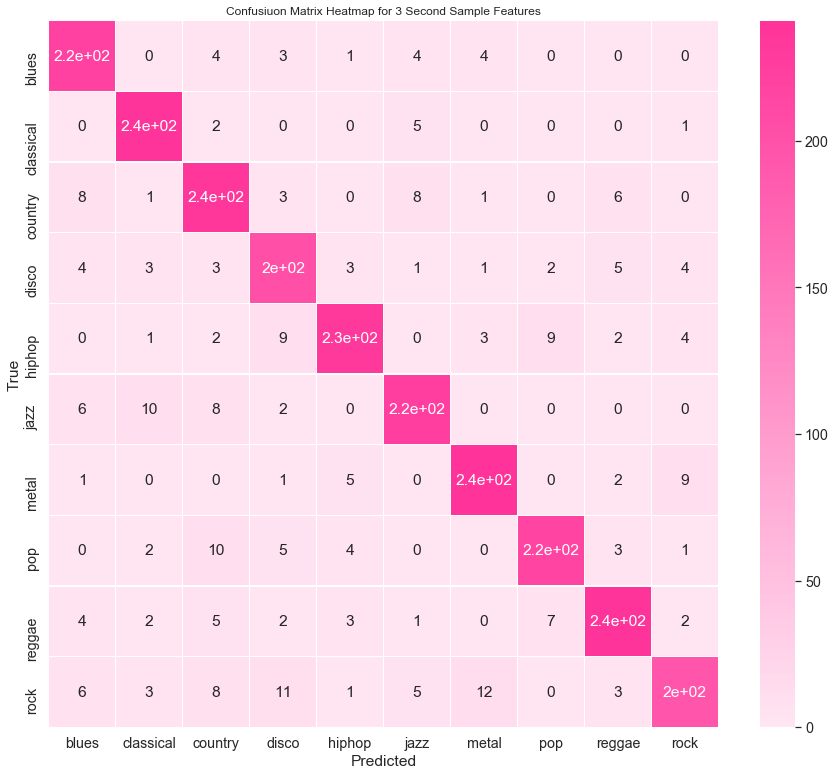

In [18]:
# Plot confusion matrix as a heatmap
sortedlabels = genre_nums.keys()
cm_df = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)

sns.set(font_scale=1.3)
sns.heatmap(cm_df, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6), n_colors=10000), annot=True)
sns.set(rc={"figure.figsize": (15.0, 13.0)})

plt.title("Confusiuon Matrix Heatmap for 3 Second Sample Features")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [19]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, rf_3_pred)
acc_score

0.899519615692554

In [20]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, rf_3_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       236
           1       0.92      0.97      0.94       247
           2       0.85      0.90      0.87       263
           3       0.85      0.89      0.87       229
           4       0.93      0.89      0.91       262
           5       0.90      0.90      0.90       251
           6       0.92      0.93      0.93       259
           7       0.92      0.90      0.91       242
           8       0.92      0.90      0.91       265
           9       0.90      0.80      0.85       244

    accuracy                           0.90      2498
   macro avg       0.90      0.90      0.90      2498
weighted avg       0.90      0.90      0.90      2498



In [21]:
# Add classification report data to DataFrames
classification_report_3_second = sklearn.metrics.classification_report(y_test, rf_3_pred, output_dict=True)
genre_metrics = {}
for i in range(10):
    genre_metrics[str(i)] = classification_report_3_second[str(i)]
total_accuracy = classification_report_3_second["accuracy"]
common_metrics = {"macro avg": classification_report_3_second["macro avg"],
                  "weighted avg": classification_report_3_second["weighted avg"]}
genre_metrics_df = pd.DataFrame.from_dict(genre_metrics)
genre_metrics_df.columns = list(genre_nums.keys())
common_metrics_df = pd.DataFrame.from_dict(common_metrics)

In [22]:
# Write genre_metrics_df to JSON file
result = genre_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(os.path.join("Post_Analysis_Data", "Genre_Metrics_3_Sec.json"), "wt")
n = text_file.write(pretty_json)
text_file.close()

In [23]:
# Write common_metrics_df to JSON file
result = common_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(os.path.join("Post_Analysis_Data", "common_metrics_3_Sec.json"), "wt")
n = text_file.write(pretty_json)
text_file.close()

In [24]:
# Most important features
# List in descending order by feature importance
importances = rf_3_model.feature_importances_
sorted(zip(importances, X), reverse=True)[:5]

[(0.05386585231433961, 'perceptr_var'),
 (0.0372536649997969, 'rms_var'),
 (0.03611055907635382, 'chroma_stft_mean'),
 (0.034173230919750254, 'rms_mean'),
 (0.032685506050291045, 'mfcc4_mean')]

### `features_30_sec.csv`

In [25]:
# Separate Features (X) from the Target (y)
y = features_30_df["label"]
X = features_30_df.drop(columns="label", axis=1)

In [26]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0            0.350088         0.088757  0.130228  0.002827   
1            0.340914         0.094980  0.095948  0.002373   
2            0.363637         0.085275  0.175570  0.002746   
3            0.404785         0.093999  0.141093  0.006346   
4            0.308526         0.087841  0.091529  0.002303   
..                ...              ...       ...       ...   
995          0.352063         0.080487  0.079486  0.000345   
996          0.398687         0.075086  0.076458  0.000588   
997          0.432142         0.075268  0.081651  0.000322   
998          0.362485         0.091506  0.083860  0.001211   
999          0.358401         0.085884  0.054454  0.000336   

     spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0               1784.165850          129774.064525              2002.449060   
1               1530.176679          375850.073649              2039.036516   
2               1552.811865          156467.643368              1747.702312   
3               1070.106615          184355.942417              1596.412872   
4               1835.004266          343399.939274              1748.172116   
..                      ...                    ...                      ...   
995             2008.149458          282174.689224              2106.541053   
996             2006.843354          182114.709510              2068.942009   
997             2077.526598          231657.968040              1927.293153   
998             1398.699344          240318.731073              1818.450280   
999             1609.795082          422203.216152              1797.213044   

     spectral_bandwidth_var  rolloff_mean   rolloff_var  ...  mfcc16_mean  \
0              85882.761315   3805.839606  9.015054e+05  ...     0.752740   
1             213843.755497   3550.522098  2.977893e+06  ...     0.927998   
2              76254.192257   3042.260232  7.840345e+05  ...     2.451690   
3             166441.494769   2184.745799  1.493194e+06  ...     0.780874   
4              88445.209036   3579.757627  1.572978e+06  ...    -4.520576   
..                      ...           ...           ...  ...          ...   
995            88609.749506   4253.557033  1.222421e+06  ...     1.789867   
996            82426.016726   4149.338328  1.046621e+06  ...     3.739020   
997            74717.124394   4031.405321  8.042154e+05  ...     1.838090   
998           109090.207161   3015.631004  1.332712e+06  ...    -2.812176   
999           120115.632927   3246.908930  1.753476e+06  ...     1.794104   

     mfcc16_var  mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  \
0     52.420910    -1.690215   36.524071    -0.408979   41.597103   
1     55.356403    -0.731125   60.314529     0.295073   48.120598   
2     40.598766    -7.729093   47.639427    -1.816407   52.382141   
3     44.427753    -3.319597   50.206673     0.636965   37.319130   
4     86.099236    -5.454034   75.269707    -0.916874   53.613918   
..          ...          ...         ...          ...         ...   
995   45.050526   -13.289984   41.754955     2.484145   36.778877   
996   33.851742   -10.848309   39.395096     1.881229   32.010040   
997   33.597008   -12.845291   36.367264     3.440978   36.001110   
998   46.324894    -4.416050   43.583942     1.556207   34.331261   
999   59.167755    -7.069775   73.760391     0.028346   76.504326   

     mfcc19_mean  mfcc19_var  mfcc20_mean  mfcc20_var  
0      -2.303523   55.062923     1.221291   46.936035  
1      -0.283518   51.106190     0.531217   45.786282  
2      -3.439720   46.639660    -2.231258   30.573025  
3      -0.619121   37.259739    -3.407448   31.949339  
4      -4.404827   62.910812   -11.703234   55.195160  
..           ...         ...          ...         ...  
995    -6.713265   54.866825    -1.193787   49.950665  
996    -7.461491   39.196327    -2.795338   31.773624  
997   -12.588070   42.502201    -2.106337   29.865515

In [27]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [28]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [29]:
# Instantiate the model with RandomizedSearchCV optimized hyperparameters
rf_30_model = RandomForestClassifier(n_estimators=800, min_samples_split=5, min_samples_leaf=1,
                                     max_features="sqrt", max_depth=90, bootstrap=False)

# Fit the model
rf_30_model = rf_30_model.fit(X_train, y_train)

# Make predicitions using the testing data
rf_30_pred = rf_30_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": rf_30_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

Prediction  Actual
0             9       9
1             8       8
2             2       2
3             5       5
4             6       6
..          ...     ...
245           4       4
246           9       3
247           9       0
248           4       4
249           6       6

[250 rows x 2 columns]

In [30]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, rf_30_pred)

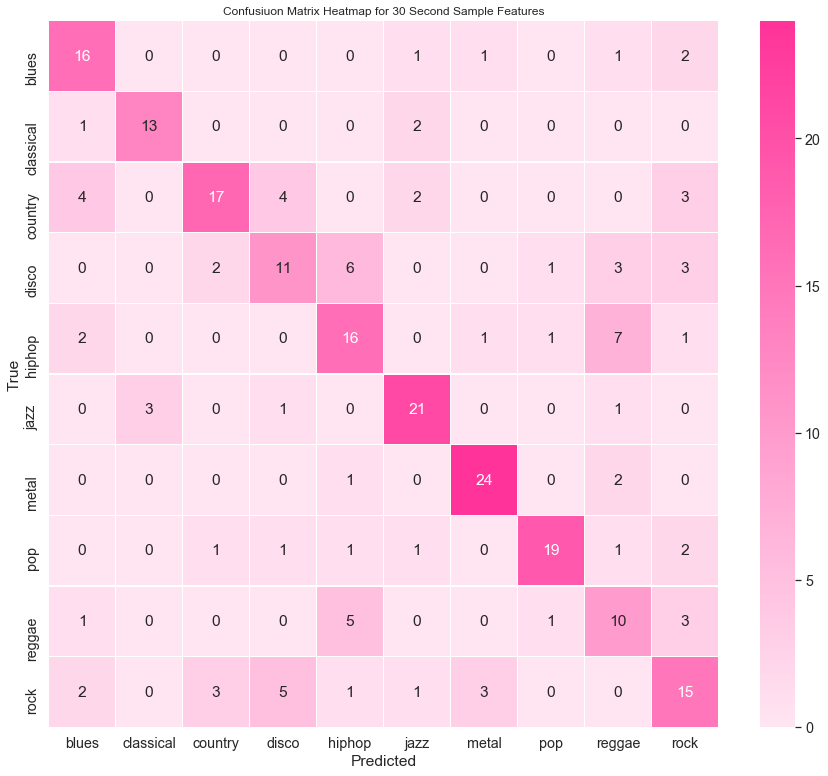

In [31]:
# Plot confusion matrix as a heatmap
sortedlabels = genre_nums.keys()
cm = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)
sns.set(font_scale=1.3)
sns.heatmap(cm, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6), n_colors=10000), annot=True)
sns.set(rc={"figure.figsize": (15.0, 13.0)})

plt.title("Confusiuon Matrix Heatmap for 30 Second Sample Features")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [32]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, rf_30_pred)
acc_score

0.648

In [33]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, rf_30_pred))

              precision    recall  f1-score   support

           0       0.62      0.76      0.68        21
           1       0.81      0.81      0.81        16
           2       0.74      0.57      0.64        30
           3       0.50      0.42      0.46        26
           4       0.53      0.57      0.55        28
           5       0.75      0.81      0.78        26
           6       0.83      0.89      0.86        27
           7       0.86      0.73      0.79        26
           8       0.40      0.50      0.44        20
           9       0.52      0.50      0.51        30

    accuracy                           0.65       250
   macro avg       0.66      0.66      0.65       250
weighted avg       0.66      0.65      0.65       250



In [34]:
# Add classification report data to DataFrames
classification_report_30_second = sklearn.metrics.classification_report(y_test, rf_30_pred, output_dict=True)
genre_metrics = {}
for i in range(10):
    genre_metrics[str(i)] = classification_report_30_second[str(i)]
total_accuracy = classification_report_30_second["accuracy"]
common_metrics = {"macro avg": classification_report_30_second["macro avg"],
                  "weighted avg": classification_report_30_second["weighted avg"]}
genre_metrics_df = pd.DataFrame.from_dict(genre_metrics)
genre_metrics_df.columns = list(genre_nums.keys())
common_metrics_df = pd.DataFrame.from_dict(common_metrics)

In [35]:
# Write genre_metrics_df to JSON file
result = genre_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(os.path.join("Post_Analysis_Data", "Genre_metrics_30_Sec.json"), "wt")
n = text_file.write(pretty_json)
text_file.close()

In [36]:
# Write common_metrics_df to JSON file
result = common_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(os.path.join("Post_Analysis_Data", "common_metrics_30_Sec.json"), "wt")
n = text_file.write(pretty_json)
text_file.close()

In [37]:
# Most important features
# List in descending order by feature importance
importances = rf_30_model.feature_importances_
sorted(zip(importances, X), reverse=True)[:5]

[(0.05157064159783011, 'perceptr_var'),
 (0.050792781530184995, 'chroma_stft_mean'),
 (0.035305286234395536, 'rms_mean'),
 (0.03424337305086746, 'rms_var'),
 (0.031775437025619635, 'chroma_stft_var')]

# Unsupervised Machine Learning
## `KMeans` Cluster
### `features_3_sec.csv`

In [38]:
# Unsupervised Machine Learning Models to Predict `label` from feature data
# K-Means Cluster Model with 10 clusters (10 known genres)
# First shuffle the rows in DataFrame so the classes are not pre-grouped
# Needed here since not using sklearn.model_selection.train_test_split (no testing data)
features_3_df_shuffled = features_3_df.sample(frac=1)
features_3_df_shuffled

filename  length  chroma_stft_mean  chroma_stft_var  \
5088       jazz.00009.6.wav   66149          0.221291         0.081859   
9666       rock.00067.6.wav   66149          0.386633         0.086335   
2371    country.00037.6.wav   66149          0.360624         0.081432   
7240        pop.00024.8.wav   66149          0.392955         0.091159   
734       blues.00073.4.wav   66149          0.337628         0.086504   
...                     ...     ...               ...              ...   
1528  classical.00053.0.wav   66149          0.350281         0.075387   
4189     hiphop.00019.5.wav   66149          0.446381         0.087372   
7985        pop.00099.3.wav   66149          0.378494         0.082973   
2926    country.00093.1.wav   66149          0.267690         0.097167   
6567      metal.00057.5.wav   66149          0.453371         0.073227   

      rms_mean   rms_var  spectral_centroid_mean  spectral_centroid_var  \
5088  0.094267  0.000377              664.151865           17961.539493   
9666  0.119362  0.001578             2486.526140          349345.060852   
2371  0.082311  0.000653             1848.915848          257851.386342   
7240  0.271499  0.008213             3224.620276          903827.959269   
734   0.288707  0.006478             2135.412360           97216.711876   
...        ...       ...                     ...                    ...   
1528  0.144285  0.002340             1425.109240           64377.076003   
4189  0.248611  0.008834             2372.749135          623141.995540   
7985  0.136910  0.003881             2836.392085          745011.339701   
2926  0.119617  0.002575             1655.995802          622636.370779   
6567  0.212715  0.001147             2711.175352          148799.943542   

      spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
5088              1179.382242            70592.581265  ...   12.342857   
9666              2456.644803            40042.519867  ...   41.514812   
2371              2257.899241           134013.662647  ...   37.276134   
7240              3073.851642           143561.688820  ...   43.165398   
734               2130.999750            41693.312486  ...   34.825615   
...                       ...                     ...  ...         ...   
1528              1522.399224            57970.516832  ...   18.161182   
4189              2374.914452           373087.043018  ...   46.600773   
7985              3153.887107           118866.457422  ...   53.920418   
2926              1705.752695            91632.037153  ...   51.999882   
6567              2229.892320            74328.356409  ...   26.307400   

      mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  \
5088    -9.549417   31.650089    -1.465381   38.866783     2.286390   
9666   -10.817902   23.838116     2.056116   28.145052   -10.132632   
2371    -7.897534   35.630482    -9.547262   65.584618    -9.446836   
7240     3.332337   45.289131     4.275846   60.548843     3.330143   
734     -5.451715   42.439354     3.659309   26.960596     2.685969   
...           ...         ...          ...         ...          ...   
1528     1.318430   25.124985     2.957204   36.569244    -5.937955   
4189    -2.028583   58.748161     3.657158   88.667099    -0.056988   
7985    -0.991700   75.543716     5.841761   79.691734    -2.218396   
2926   -10.429054  127.361267    -7.566647  146.887680    -3.632076   
6567    -7.922630   49.253246     2.741748   32.673145    -9.517612   

      mfcc19_var  mfcc20_mean  mfcc20_var      label  
5088   37.323830    -4.713659   32.845493       jazz  
9666   34.652359    -0.332278   28.385437       rock  
2371   88.990265    -2.871985   44.538101    country  
7240   60.995789     3.536944   89.971146        pop  
734    64.746887     9.078094  109.014091      blues  
...          ...          ...         ...        ...  
1528   30.521286    -1.112114   12.377980  classical  
4189   66.002609    -0.985863   62.178898     h

In [39]:
# Separate Features (X) from the Target (y)
y = features_3_df_shuffled["label"]
X = features_3_df_shuffled.drop(columns="label", axis=1)

In [40]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
5088          0.221291         0.081859  0.094267  0.000377   
9666          0.386633         0.086335  0.119362  0.001578   
2371          0.360624         0.081432  0.082311  0.000653   
7240          0.392955         0.091159  0.271499  0.008213   
734           0.337628         0.086504  0.288707  0.006478   
...                ...              ...       ...       ...   
1528          0.350281         0.075387  0.144285  0.002340   
4189          0.446381         0.087372  0.248611  0.008834   
7985          0.378494         0.082973  0.136910  0.003881   
2926          0.267690         0.097167  0.119617  0.002575   
6567          0.453371         0.073227  0.212715  0.001147   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
5088              664.151865           17961.539493              1179.382242   
9666             2486.526140          349345.060852              2456.644803   
2371             1848.915848          257851.386342              2257.899241   
7240             3224.620276          903827.959269              3073.851642   
734              2135.412360           97216.711876              2130.999750   
...                      ...                    ...                      ...   
1528             1425.109240           64377.076003              1522.399224   
4189             2372.749135          623141.995540              2374.914452   
7985             2836.392085          745011.339701              3153.887107   
2926             1655.995802          622636.370779              1705.752695   
6567             2711.175352          148799.943542              2229.892320   

      spectral_bandwidth_var  rolloff_mean   rolloff_var  ...  mfcc16_mean  \
5088            70592.581265    933.878456  3.188069e+04  ...   -17.145573   
9666            40042.519867   5549.603365  8.027994e+05  ...     2.629873   
2371           134013.662647   3620.973745  1.955437e+06  ...    -5.763032   
7240           143561.688820   6876.297138  2.567173e+06  ...    -0.490344   
734             41693.312486   4522.221116  5.070568e+05  ...     5.604892   
...                      ...           ...           ...  ...          ...   
1528            57970.516832   2681.629169  3.201777e+05  ...     4.078187   
4189           373087.043018   5067.590895  3.097885e+06  ...    -0.930836   
7985           118866.457422   6912.075383  3.376956e+06  ...    -6.739311   
2926            91632.037153   3202.815505  1.506391e+06  ...    -7.541651   
6567            74328.356409   5110.988582  7.980688e+05  ...     4.819415   

      mfcc16_var  mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  \
5088   12.342857    -9.549417   31.650089    -1.465381   38.866783   
9666   41.514812   -10.817902   23.838116     2.056116   28.145052   
2371   37.276134    -7.897534   35.630482    -9.547262   65.584618   
7240   43.165398     3.332337   45.289131     4.275846   60.548843   
734    34.825615    -5.451715   42.439354     3.659309   26.960596   
...          ...          ...         ...          ...         ...   
1528   18.161182     1.318430   25.124985     2.957204   36.569244   
4189   46.600773    -2.028583   58.748161     3.657158   88.667099   
7985   53.920418    -0.991700   75.543716     5.841761   79.691734   
2926   51.999882   -10.429054  127.361267    -7.566647  146.887680   
6567   26.307400    -7.922630   49.253246     2.741748   32.673145   

      mfcc19_mean  mfcc19_var  mfcc20_mean  mfcc20_var  
5088     2.286390   37.323830    -4.713659   32.845493  
9666   -10.132632   34.652359    -0.332278   28.385437  
2371    -9.446836   88.990265    -2.871985   44.538101  
7240     3.330143   60.995789     3.536944   89.971146  
734      2.685969   64.746887     9.078094  109.014091  
...           ...         ...          ...         ...  
1528    -5.937955   30.521286    -1.112114   12.377980  
4189    -0.056988   66.002609    -0.985863   62.178898

In [41]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'jazz': 0,
 'rock': 1,
 'country': 2,
 'pop': 3,
 'blues': 4,
 'hiphop': 5,
 'classical': 6,
 'reggae': 7,
 'metal': 8,
 'disco': 9}

In [42]:
# Standardize features with StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Initialize PCA model with 3 principal components to visualize clusters vs. components
pca = PCA(n_components=3)

# Fit pca model to the 30 sec music feature data, X
X_pca = pca.fit_transform(X_scaled)

# Transform PCA data to a DataFrame
df_pca = pd.DataFrame(
    data=X_pca, columns=["principal component 1", "principal component 2", "principal component 3"]
)
df_pca.head()

principal component 1  principal component 2  principal component 3
0              -3.254056               3.701740              -2.815263
1              -2.380947              -1.762988               2.318684
2               0.052016               1.948853              -2.366672
3               3.960886              -3.343061              -2.666148
4              -1.536862              -2.289996               1.537342

In [43]:
# Fetch the explained variance
pca.explained_variance_ratio_  # 1st component contains 20% of variance, 2nd contains 14%, 3rd contains 10%

array([0.20054986, 0.13542712, 0.1034532 ])

In [44]:
# Initialize the K-means model
km_3_model = KMeans(n_clusters=10, random_state=0)

# Fit the model
km_3_model.fit(df_pca)

# Predict clusters
predictions = km_3_model.predict(df_pca)

# Add the predicted and actual class columns
pred_classes = []
act_classes = []

for label in km_3_model.labels_:
    pred_classes.append(list(genre_nums.keys())[list(genre_nums.values()).index(label)])
for label in np.asarray(y):
    act_classes.append(list(genre_nums.keys())[list(genre_nums.values()).index(label)])

df_pca["predicted class"] = pred_classes
df_pca["actual class"] = act_classes
df_pca

principal component 1  principal component 2  principal component 3  \
0                 -3.254056               3.701740              -2.815263   
1                 -2.380947              -1.762988               2.318684   
2                  0.052016               1.948853              -2.366672   
3                  3.960886              -3.343061              -2.666148   
4                 -1.536862              -2.289996               1.537342   
...                     ...                    ...                    ...   
9985              -3.177137               0.775521              -2.714308   
9986               3.204171              -2.062207               2.491606   
9987               3.350872              -0.911455              -2.529387   
9988               1.526944               3.316951               2.438430   
9989              -2.384219              -3.065093               2.344340   

     predicted class actual class  
0                pop         jazz  
1               rock         rock  
2              disco      country  
3          classical          pop  
4               rock        blues  
...              ...          ...  
9985             pop    classical  
9986          reggae       hiphop  
9987       classical          pop  
9988            jazz      country  
9989            rock        metal  

[9990 rows x 5 columns]

In [45]:
# Plotting clusters with three features
fig = px.scatter_3d(df_pca, x="principal component 1", y="principal component 2", z="principal component 3",
                    color="predicted class", symbol="predicted class", width=800, title="Predicted Genre Clusters",
                    hover_data=["actual class"])
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [46]:
# Labels not insightful, no reason for program to label all "blues" as 0
# Check number of each prediction:
df_pca["predicted class"].value_counts(sort=False)

hiphop        942
reggae       1084
rock         1905
classical     959
blues         463
pop          1069
metal         506
jazz          894
country      1065
disco        1103
Name: predicted class, dtype: int64

In [47]:
# Compare to actual class breakdown
df_pca["actual class"].value_counts(sort=False)

hiphop        998
reggae       1000
rock          998
classical     998
blues        1000
pop          1000
metal        1000
jazz         1000
country       997
disco         999
Name: actual class, dtype: int64

In [48]:
# Check number of actual class labels for a single predicted label
# Ideally we would find many of one actual class label and few of others for each predicted label, and a unique most 
# popular actual label for each predicted label
act_pred_results = np.zeros((10, 10), dtype=int)
col_names = []
for i in range(10):
    row = list(genre_nums.keys())[list(genre_nums.values()).index(i)]
    for j in range(10):
        col = list(genre_nums.keys())[list(genre_nums.values()).index(j)]
        try:
            act_pred_results[i, j] = df_pca[df_pca["predicted class"] == row]["actual class"].value_counts(sort=False)[col]
        except KeyError:
            act_pred_results[i, j] = 0
    col_names.append("Number of Actual %s" % i)

act_pred_results_df = pd.DataFrame(data=act_pred_results,
                                   columns=col_names)

In [49]:
# Add Number of actual classed for each each predicted class to DataFrame
act_pred_results_df.columns = list(genre_nums.keys())
act_pred_results_df.index = list(genre_nums.keys())
act_pred_results_df.index.rename("Predicted Class", inplace=True)
act_pred_results_df = act_pred_results_df[["jazz", "metal", "disco", "pop", "reggae", "classical", "rock", "blues", "hiphop", "country"]]
act_pred_results_df = act_pred_results_df.reindex(["jazz", "metal", "disco", "pop", "reggae", "classical", "rock", "blues", "hiphop", "country"])
act_pred_results_df

jazz  metal  disco  pop  reggae  classical  rock  blues  \
Predicted Class                                                            
jazz              183      1     11   13      64        199    13    258   
metal              29     12     15   35     191         42    20     85   
disco             146      3    130  116     215         13   134     18   
pop               242      2      1    6       8        571    33     96   
reggae              7     54    238    0     134          9   125    170   
classical           7      2     75  375     212          1    27      0   
rock               16    861    234    0      27          0   311    253   
blues               1      1      2  219      73          0     2      0   
hiphop            253     39     34    0      24        155   158    120   
country           116     25    259  236      52          8   175      0   

                 hiphop  country  
Predicted Class                   
jazz                 11      141  
metal                52       25  
disco                72      256  
pop                   4      106  
reggae              222      125  
classical           245       15  
rock                131       72  
blues               163        2  
hiphop                6      153  
country              92      102

In [50]:
# Write number of actual classes for each predicted class data to JSON file
result = act_pred_results_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(os.path.join("Post_Analysis_Data", "act_pred_3_sec.json"), "wt")
n = text_file.write(pretty_json)
text_file.close()

### `features_30_sec.csv`

In [51]:
# Unsupervised Machine Learning Models to Predict `label` from feature data
# K-Means Cluster Model with 10 clusters (10 known genres)
# First shuffle the rows in DataFrame so the classes are not pre-grouped
# Needed here since not using sklearn.model_selection.train_test_split (no testing data)
features_30_df_shuffled = features_30_df.sample(frac=1)
features_30_df_shuffled

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
101  classical.00002.wav  661794          0.277958         0.083759  0.043860   
330      disco.00030.wav  661794          0.450151         0.079865  0.170026   
945       rock.00045.wav  661794          0.361234         0.082603  0.096995   
400     hiphop.00000.wav  661504          0.460728         0.085172  0.125275   
973       rock.00073.wav  661794          0.458529         0.074670  0.169360   
..                   ...     ...               ...              ...       ...   
40       blues.00040.wav  661794          0.397996         0.080510  0.134892   
609      metal.00009.wav  661504          0.527149         0.060691  0.312847   
542       jazz.00042.wav  661794          0.285061         0.090716  0.099519   
505       jazz.00005.wav  661794          0.248190         0.096409  0.107565   
293    country.00093.wav  661794          0.251088         0.090910  0.092552   

      rms_var  spectral_centroid_mean  spectral_centroid_var  \
101  0.000193             1490.275364           38993.337531   
330  0.004634             3167.833752          670950.429060   
945  0.000815             1560.999792           90382.491401   
400  0.002465             2667.940502          418523.003280   
973  0.002163             2223.937480          292577.658740   
..        ...                     ...                    ...   
40   0.000777             2272.439547          202304.929187   
609  0.001024             2250.699842           96695.391994   
542  0.003935             1344.255959          186927.234864   
505  0.002235             1268.325308          286413.985546   
293  0.001750             1537.649194          339244.053816   

     spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
101              1600.115744            31200.899044  ...   85.150917   
330              3047.736411            80131.589191  ...   33.383942   
945              1568.308311            10787.185064  ...   25.971584   
400              2351.160744           107829.332778  ...   55.406570   
973              2287.733702            52772.345554  ...   30.815691   
..                       ...                     ...  ...         ...   
40               2356.806514            50239.390586  ...   35.453495   
609              2389.995078            25846.725192  ...   29.895109   
542              1548.735703            40061.855918  ...   58.647270   
505              1546.237439           236513.711094  ...  229.142059   
293              1716.109737            95779.446328  ...   94.190422   

     mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  \
101    -1.309433   77.170746     2.945177   74.202652    -1.655027   
330    -4.741262   31.170950    -5.762606   25.344149    -4.028023   
945   -11.281557   17.765968    -7.829482   20.357563    -7.715235   
400    -5.377674   69.421989     7.692775   62.197952    -5.553035   
973    -8.277468   30.002546     1.591410   49.309982    -7.033374   
..           ...         ...          ...         ...          ...   
40     -5.692046   39.637764    -3.643349   36.257603    -4.852754   
609    -6.499887   21.449266     4.899444   19.926039    -0.785289   
542    -0.941571   68.595711    -1.291303   64.309059    -2.233084   
505     0.888774  406.058868     0.979152  332.905426     1.729311   
293    -9.719612   83.541512    -3.209922   71.195091    -4.459054   

     mfcc19_var  mfcc20_mean  mfcc20_var      label  
101   59.096081    -2.896193   53.000435  classical  
330   25.110504    -5.362844   24.809027      disco  
945   21.045958    -8.141011   21.702080       rock  
400   63.344887     1.516093   41.072289     hiphop  
973   32.456982    -0.822743   37.815281       rock  
..          ...          ...         ...        ...  
40    48.273891     1.853227   46.011623      blues  
609   19.250475     6.461120   18.508450      metal  
542   97.187370    -3.274121  100.953384       jazz  
505  193.043182 

In [52]:
# Separate Features (X) from the Target (y)
y = features_30_df_shuffled["label"]
X = features_30_df_shuffled.drop(columns="label", axis=1)

In [53]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
101          0.277958         0.083759  0.043860  0.000193   
330          0.450151         0.079865  0.170026  0.004634   
945          0.361234         0.082603  0.096995  0.000815   
400          0.460728         0.085172  0.125275  0.002465   
973          0.458529         0.074670  0.169360  0.002163   
..                ...              ...       ...       ...   
40           0.397996         0.080510  0.134892  0.000777   
609          0.527149         0.060691  0.312847  0.001024   
542          0.285061         0.090716  0.099519  0.003935   
505          0.248190         0.096409  0.107565  0.002235   
293          0.251088         0.090910  0.092552  0.001750   

     spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
101             1490.275364           38993.337531              1600.115744   
330             3167.833752          670950.429060              3047.736411   
945             1560.999792           90382.491401              1568.308311   
400             2667.940502          418523.003280              2351.160744   
973             2223.937480          292577.658740              2287.733702   
..                      ...                    ...                      ...   
40              2272.439547          202304.929187              2356.806514   
609             2250.699842           96695.391994              2389.995078   
542             1344.255959          186927.234864              1548.735703   
505             1268.325308          286413.985546              1546.237439   
293             1537.649194          339244.053816              1716.109737   

     spectral_bandwidth_var  rolloff_mean   rolloff_var  ...  mfcc16_mean  \
101            31200.899044   2785.294011  2.748354e+05  ...     3.171561   
330            80131.589191   6935.373428  1.698842e+06  ...    -4.721450   
945            10787.185064   3242.912048  2.820887e+05  ...    -4.284111   
400           107829.332778   5475.312341  1.564158e+06  ...     7.323508   
973            52772.345554   4917.439174  9.273025e+05  ...     4.410295   
..                      ...           ...           ...  ...          ...   
40             50239.390586   5108.215360  5.814972e+05  ...     6.544709   
609            25846.725192   5112.145628  2.512005e+05  ...     9.865374   
542            40061.855918   2771.762899  1.120919e+06  ...    -6.155101   
505           236513.711094   2486.626985  1.862016e+06  ...     7.082913   
293            95779.446328   3055.325041  1.178627e+06  ...    -5.425388   

     mfcc16_var  mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  \
101   85.150917    -1.309433   77.170746     2.945177   74.202652   
330   33.383942    -4.741262   31.170950    -5.762606   25.344149   
945   25.971584   -11.281557   17.765968    -7.829482   20.357563   
400   55.406570    -5.377674   69.421989     7.692775   62.197952   
973   30.815691    -8.277468   30.002546     1.591410   49.309982   
..          ...          ...         ...          ...         ...   
40    35.453495    -5.692046   39.637764    -3.643349   36.257603   
609   29.895109    -6.499887   21.449266     4.899444   19.926039   
542   58.647270    -0.941571   68.595711    -1.291303   64.309059   
505  229.142059     0.888774  406.058868     0.979152  332.905426   
293   94.190422    -9.719612   83.541512    -3.209922   71.195091   

     mfcc19_mean  mfcc19_var  mfcc20_mean  mfcc20_var  
101    -1.655027   59.096081    -2.896193   53.000435  
330    -4.028023   25.110504    -5.362844   24.809027  
945    -7.715235   21.045958    -8.141011   21.702080  
400    -5.553035   63.344887     1.516093   41.072289  
973    -7.033374   32.456982    -0.822743   37.815281  
..           ...         ...          ...         ...  
40     -4.852754   48.273891     1.853227   46.011623  
609    -0.785289   19.250475     6.461120   18.508450  
542    -2.233084   97.187370    -3.274121  100.953384

In [54]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'classical': 0,
 'disco': 1,
 'rock': 2,
 'hiphop': 3,
 'country': 4,
 'blues': 5,
 'jazz': 6,
 'pop': 7,
 'reggae': 8,
 'metal': 9}

In [55]:
# Standardize features with StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Initialize PCA model with 3 principal components to visualize clusters vs. components
pca = PCA(n_components=3)

# Fit pca model to the 30 sec music feature data, X
X_pca = pca.fit_transform(X_scaled)

# Transform PCA data to a DataFrame
df_pca = pd.DataFrame(
    data=X_pca, columns=["principal component 1", "principal component 2", "principal component 3"]
)
df_pca.head()

principal component 1  principal component 2  principal component 3
0              -2.079981              -4.377599              -0.163794
1              -0.627626               4.093069              -3.506591
2              -3.222243              -2.447272              -5.742696
3              -3.057570               0.636011               4.120825
4              -5.793663               0.800400               0.932488

In [56]:
# Fetch the explained variance
pca.explained_variance_ratio_  # 1st component contains 24% of variance, 2nd contains 17%, 3rd contains 11%

array([0.23949564, 0.16929248, 0.10750028])

In [57]:
# Initialize the K-means model
km_30_model = KMeans(n_clusters=10, random_state=0)

# Fit the model
km_30_model.fit(df_pca)

# Predict clusters
predictions = km_30_model.predict(df_pca)

# Add the predicted and actual class columns
pred_classes = []
act_classes = []

for label in km_30_model.labels_:
    pred_classes.append(list(genre_nums.keys())[list(genre_nums.values()).index(label)])
for label in np.asarray(y):
    act_classes.append(list(genre_nums.keys())[list(genre_nums.values()).index(label)])

# Add the preicted class columns
df_pca["predicted class"] = pred_classes
df_pca["actual class"] = act_classes
df_pca

principal component 1  principal component 2  principal component 3  \
0                -2.079981              -4.377599              -0.163794   
1                -0.627626               4.093069              -3.506591   
2                -3.222243              -2.447272              -5.742696   
3                -3.057570               0.636011               4.120825   
4                -5.793663               0.800400               0.932488   
..                     ...                    ...                    ...   
995              -5.680956              -0.448964               1.213608   
996              -7.406128               3.082381               1.459368   
997              -0.160156              -3.453775              -2.454595   
998              10.013101              -8.034880               7.299468   
999               1.923801              -3.807970               1.065761   

    predicted class actual class  
0            hiphop    classical  
1              jazz        disco  
2            hiphop         rock  
3         classical       hiphop  
4           country         rock  
..              ...          ...  
995         country        blues  
996         country        metal  
997          hiphop         jazz  
998             pop         jazz  
999          reggae      country  

[1000 rows x 5 columns]

In [58]:
# Plotting clusters with three features
fig = px.scatter_3d(df_pca, x="principal component 1", y="principal component 2", z="principal component 3",
                    color="predicted class", symbol="predicted class", width=800, title="Predicted Genre Clusters",
                    hover_data=["actual class"])
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [59]:
# Labels not insightful, no reason for program to label all "blues" as 0
# Check number of each prediction:
df_pca["predicted class"].value_counts(sort=False)

reggae       111
jazz         118
rock         101
classical    150
pop           12
country      179
blues         76
hiphop       103
metal         87
disco         63
Name: predicted class, dtype: int64

In [60]:
# Compare to actual class breakdown
df_pca["actual class"].value_counts(sort=False)

reggae       100
jazz         100
rock         100
classical    100
pop          100
country      100
blues        100
hiphop       100
metal        100
disco        100
Name: actual class, dtype: int64

In [61]:
# Check number of actual class labels for a single predicted label
# Ideally we would find many of one actual class label and few of others for each predicted label, and a unique most 
# popular actual label for each predicted label
act_pred_results = np.zeros((10, 10), dtype=int)
col_names = []
for i in range(10):
    row = list(genre_nums.keys())[list(genre_nums.values()).index(i)]
    for j in range(10):
        col = list(genre_nums.keys())[list(genre_nums.values()).index(j)]
        try:
            act_pred_results[i, j] = df_pca[df_pca["predicted class"] == row]["actual class"].value_counts(sort=False)[col]
        except KeyError:
            act_pred_results[i, j] = 0
    col_names.append("Number of Actual %s" % i)

act_pred_results_df = pd.DataFrame(data=act_pred_results,
                                   columns=col_names)

In [62]:
# Add Number of actual classed for each each predicted class to DataFrame
act_pred_results_df.columns = list(genre_nums.keys())
act_pred_results_df.index = list(genre_nums.keys())
act_pred_results_df.index.rename("Predicted Class", inplace=True)
act_pred_results_df = act_pred_results_df[["jazz", "metal", "disco", "pop", "reggae", "classical", "rock", "blues", "hiphop", "country"]]
act_pred_results_df = act_pred_results_df.reindex(["jazz", "metal", "disco", "pop", "reggae", "classical", "rock", "blues", "hiphop", "country"])
act_pred_results_df

jazz  metal  disco  pop  reggae  classical  rock  blues  \
Predicted Class                                                            
jazz               16      3     30   10       8          1    24      0   
metal               1      0      9   39      10          0     1      0   
disco               0      1      6    0      27          1     6      3   
pop                 3      0      0    4       1          4     0      0   
reggae             20      0      1    2       2         39     0     31   
classical          12     11     27    0       7          3    23     25   
rock                8      0      7   10      24          4     9     13   
blues               1      0      0   35      18          0     2      0   
hiphop             36      0      0    0       1         48     3      6   
country             3     85     20    0       2          0    32     22   

                 hiphop  country  
Predicted Class                   
jazz                  7       19  
metal                27        0  
disco                16        3  
pop                   0        0  
reggae                0       16  
classical            19       23  
rock                  3       23  
blues                19        1  
hiphop                0        9  
country               9        6

In [63]:
# Write number of actual classes for each predicted class data to JSON file
result = act_pred_results_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(os.path.join("Post_Analysis_Data", "act_pred_30_sec.json"), "wt")
n = text_file.write(pretty_json)
text_file.close()

# Neural Network to Predict `label` from Images

In [64]:
# Copy images and labels into new NumPy arrays
X = np.copy(images)
y = np.copy(genres)

In [65]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in np.unique(y):
    genre_nums[genre] = cnt
    cnt += 1

genre_nums

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [66]:
# Convert categorical labels to integers 0 - 9
y = np.vectorize(genre_nums.get)(y)

In [67]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [68]:
# Normalize pixel data:
X_train = X_train / 255
X_test = X_test / 255

In [69]:
# Define Neural Net
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[288, 432]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")])

In [70]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 124416)            0         
_________________________________________________________________
dense (Dense)                (None, 300)               37325100  
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 37,376,410
Trainable params: 37,376,410
Non-trainable params: 0
____________________________________________

In [71]:
# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [72]:
# Train the model
history = model.fit(X_train, y_train, epochs=200)

Epoch 1/200
24/24 [==============================] - 3s 112ms/step - loss: 2.9234 - accuracy: 0.0964
Epoch 2/200
24/24 [==============================] - 3s 112ms/step - loss: 2.3060 - accuracy: 0.0996
Epoch 3/200
24/24 [==============================] - 3s 108ms/step - loss: 2.3228 - accuracy: 0.0996
Epoch 4/200
24/24 [==============================] - 3s 108ms/step - loss: 2.2922 - accuracy: 0.1357
Epoch 5/200
24/24 [==============================] - 3s 109ms/step - loss: 2.2944 - accuracy: 0.1283
Epoch 6/200
24/24 [==============================] - 3s 109ms/step - loss: 2.2783 - accuracy: 0.1716
Epoch 7/200
24/24 [==============================] - 3s 108ms/step - loss: 2.2675 - accuracy: 0.1623
Epoch 8/200
24/24 [==============================] - 3s 108ms/step - loss: 2.2209 - accuracy: 0.2047
Epoch 9/200
24/24 [==============================] - 3s 109ms/step - loss: 2.2124 - accuracy: 0.1768
Epoch 10/200
24/24 [==============================] - 3s 108ms/step - loss: 2.2285 - accura

24/24 [==============================] - 3s 107ms/step - loss: 1.8050 - accuracy: 0.3287
Epoch 82/200
24/24 [==============================] - 3s 106ms/step - loss: 1.8149 - accuracy: 0.3210
Epoch 83/200
24/24 [==============================] - 3s 106ms/step - loss: 1.8529 - accuracy: 0.3298
Epoch 84/200
24/24 [==============================] - 3s 108ms/step - loss: 1.7465 - accuracy: 0.3430
Epoch 85/200
24/24 [==============================] - 3s 107ms/step - loss: 1.7553 - accuracy: 0.3356
Epoch 86/200
24/24 [==============================] - 3s 107ms/step - loss: 1.8354 - accuracy: 0.3211
Epoch 87/200
24/24 [==============================] - 3s 107ms/step - loss: 1.7594 - accuracy: 0.3234
Epoch 88/200
24/24 [==============================] - 3s 107ms/step - loss: 1.8797 - accuracy: 0.3142
Epoch 89/200
24/24 [==============================] - 3s 106ms/step - loss: 1.7491 - accuracy: 0.3433
Epoch 90/200
24/24 [==============================] - 3s 107ms/step - loss: 1.6899 - accuracy: 

24/24 [==============================] - 3s 106ms/step - loss: 1.5469 - accuracy: 0.4376
Epoch 161/200
24/24 [==============================] - 3s 106ms/step - loss: 1.6045 - accuracy: 0.4213
Epoch 162/200
24/24 [==============================] - 3s 106ms/step - loss: 1.5763 - accuracy: 0.4338
Epoch 163/200
24/24 [==============================] - 3s 106ms/step - loss: 1.5342 - accuracy: 0.4148
Epoch 164/200
24/24 [==============================] - 3s 105ms/step - loss: 1.5403 - accuracy: 0.4372
Epoch 165/200
24/24 [==============================] - 3s 105ms/step - loss: 1.5012 - accuracy: 0.4665
Epoch 166/200
24/24 [==============================] - 3s 106ms/step - loss: 1.5230 - accuracy: 0.4363
Epoch 167/200
24/24 [==============================] - 3s 106ms/step - loss: 1.5259 - accuracy: 0.4487
Epoch 168/200
24/24 [==============================] - 3s 106ms/step - loss: 1.4431 - accuracy: 0.4621
Epoch 169/200
24/24 [==============================] - 3s 106ms/step - loss: 1.5851 - a

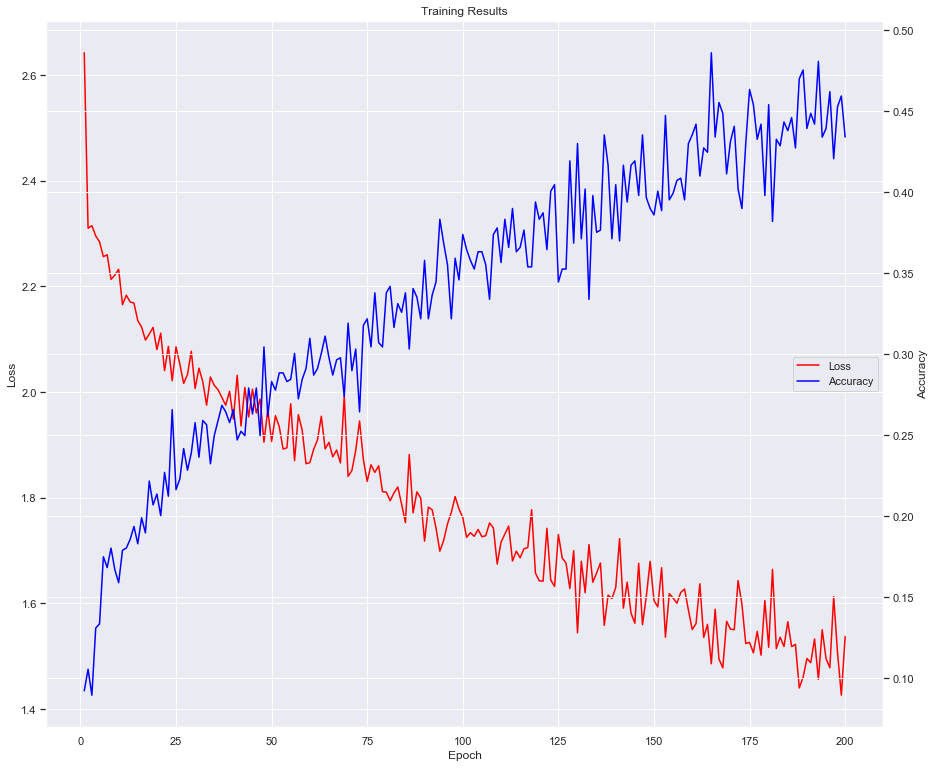

In [73]:
# Plot training results (loss and accuracy vs. epoch)
history_df = pd.DataFrame(history.history,
                          index=range(1, len(history.history["loss"]) + 1))

fig, ax = plt.subplots()
loss = ax.plot(history_df["loss"], color="red", label="Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training Results")

ax2 = ax.twinx()
acc = ax2.plot(history_df["accuracy"], color="blue", label="Accuracy")
ax2.set_ylabel("Accuracy")

curves = loss + acc
labs = [l.get_label() for l in curves]
ax.legend(curves, labs, loc="center right")

plt.show()

In [74]:
# Evaluate model
model.evaluate(X_test, y_test)  # Likely overfitting: 0.6 training accuracy -> 0.34 testing accuracy

8/8 [==============================] - 0s 25ms/step - loss: 1.9408 - accuracy: 0.3560


[1.940849781036377, 0.35600000619888306]

In [75]:
# Generate predictions from model to visualize accuracy vs. genre
nn_pred_probs = model.predict(X_test)
nn_pred = np.argmax(nn_pred_probs, axis=1)
results = pd.DataFrame({
    "Prediction": nn_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

Prediction  Actual
0             1       4
1             1       7
2             2       2
3             2       9
4             1       5
..          ...     ...
245           2       2
246           8       7
247           3       8
248           5       7
249           5       5

[250 rows x 2 columns]

In [76]:
# Generate classifcation report from y_test and nn_pred and add to DataFrame
classification_report_nn = sklearn.metrics.classification_report(y_test, nn_pred, output_dict=True)
genre_metrics = {}
for i in range(10):
    genre_metrics[str(i)] = classification_report_nn[str(i)]
total_accuracy = classification_report_nn["accuracy"]
common_metrics = {"macro avg": classification_report_nn["macro avg"],
                  "weighted avg": classification_report_nn["weighted avg"]}
genre_metrics_df = pd.DataFrame.from_dict(genre_metrics)
genre_metrics_df.columns = list(genre_nums.keys())
common_metrics_df = pd.DataFrame.from_dict(common_metrics)

In [77]:
# Print model accuracy
print("Total Accuracy:", total_accuracy)

Total Accuracy: 0.356


In [78]:
# Write genre_metrics_df to JSON file
result = genre_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(os.path.join("Post_Analysis_Data", "Genre_metrics_nn.json"), "wt")
n = text_file.write(pretty_json)
text_file.close()

In [79]:
# Write common_metrics_df to JSON file
result = common_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(os.path.join("Post_Analysis_Data", "common_metrics_30_Sec.json"), "wt")
n = text_file.write(pretty_json)
text_file.close()